In [1]:
import quantum_kan 
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import mean_squared_error, r2_score
from pyqubo import Binary, Array
import os
from dwave.embedding.chain_breaks import majority_vote
from dimod import BinaryQuadraticModel
import dwave.inspector
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, FixedEmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn
import minorminer
import networkx as nx

# Set your D-Wave API token
import os
env_vars = !cat dwave.env
for var in env_vars:
    key, value = var.split('=')
    os.environ[str(key)] = str(value)
#Advantage_system6.4 or Advantage2_prototype2.3
# sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
sampler = LeapHybridSampler(solver="hybrid_binary_quadratic_model_version2", run_time=30)

simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")


Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' in part) or ('AUX' in part):
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)
    
def separate_vars(solution):
    """
    Separate coefficients and auxiliary variables from the solution dictionary.

    :param solution: The solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {k: v for k, v in solution.items() if k.startswith('aux')}
    coeff_vars = {k: v for k, v in solution.items() if k.startswith('coeff')}
    
    return aux_vars, coeff_vars

def create_reverse_lookup_dict(original_dict):
    """
    Create a reverse lookup dictionary from the given dictionary.

    :param original_dict: The original dictionary to reverse.
    :return: A new dictionary where keys are the original values and values are the original keys.
    """
    reverse_dict = {v: k for k, v in original_dict.items()}
    return reverse_dict

def map_solution_variables(solution, reverse_dict):
    """
    Map solution variables from PyQUBO to SymPy using the reverse dictionary.

    :param solution: The solution dictionary with PyQUBO variables.
    :param reverse_dict: The reverse lookup dictionary to map PyQUBO variables to SymPy variables.
    :return: A new dictionary with SymPy variables as keys and solution values.
    """
    mapped_solution = {}
    for pyqubo_var, value in solution.items():
        sympy_var = reverse_dict.get(Binary(pyqubo_var))
        if sympy_var is not None:
            mapped_solution[sympy_var] = value
        else:
            print(f"Warning: PyQUBO variable {pyqubo_var} not found in reverse mapping.")
    return mapped_solution

def separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary=False):
    """
    Separate coefficients and auxiliary variables from the mapped solution dictionary.

    :param mapped_solution: The mapped solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if str(k).replace('"','').replace("'","").startswith('AUX')}
    if include_aux_in_binary == True:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if  str(k).replace('"','').replace("'","")}
    else:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if not str(k).replace('"','').replace("'","").startswith('AUX')}
    
    return aux_vars, binary_vars

def check_aux_variables(binary_vars, aux_vars, aux_dict_all):
    """
    Check if auxiliary variables correctly represent the product of their respective binary variables.

    :param binary_vars: Dictionary of binary variable values (e.g., {'x1': 0, 'x2': 1, ...})
    :param aux_vars: Dictionary of auxiliary variable values (e.g., {'z1': 1, 'z2': 0, ...})
    :param aux_dict_all: Dictionary mapping auxiliary variables to their respective binary variable products
                         (e.g., {'z1': x1*x2, 'z2': x2*x3, ...})
    :return: Dictionary indicating whether each auxiliary variable is correct (e.g., {'z1': True, 'z2': False, ...})
    """
    results = {}

    for aux_var, aux_expr in aux_dict_all.items():
        # Extract the binary variables involved in the product
        vars_in_expr = aux_expr.split('*')
        product_value = 1
        aux_var = str(aux_var)

        # Calculate the expected value by multiplying the values of the binary variables
        for var in vars_in_expr:
            var = str(var)
            if var in binary_vars:
                product_value *= binary_vars[var]
            else:
                raise ValueError(f"Variable {var} not found in binary_vars dictionary")

        # Check if the auxiliary variable's value matches the expected product value
        if aux_var in aux_vars:
            results[aux_var] = (aux_vars[aux_var] == product_value)
        else:
            raise ValueError(f"Auxiliary variable {aux_var} not found in aux_vars dictionary")

    return results
    
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [0,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = (train_label - mean_label) / std_label
        test_label = (test_label - mean_label) / std_label

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset



In [3]:
# Defining variables for the networks
degree1 = 1
degree2 = 2
degree3 = 1
degrees=[degree1,degree3]
m1 = 3
m2 = 4
m3 = 1

penalty_multiplier = 25
bias_coefficient = 0.0
is_fractional=True

num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1
num_basis_funcs_3 = degree3 + 1

number_of_quantum_annealing_tries = 1
annealing_mses_degree1_1 = []
annealing_r2_degree1_1 = []
annealing_coefficients_1 = []
annealing_mses_degree1_2 = []
annealing_r2_degree1_2 = []
annealing_coefficients_2 = []

In [4]:
dataset_size = 5000
# Create dataset with normalized inputs between 0 and 1
dataset_multiplier = 2
# Create dataset with normalized inputs between 0 and 1
f = lambda x: np.sqrt( 1 + x[:, [0]]**2 + x[:, [1]]**2 ) * dataset_multiplier
dataset = create_dataset(f, n_var=2, train_num=dataset_size, test_num=0, ranges=[0, 1])
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

# Generate a grid of t values for the 3D plot
t_values = np.linspace(0, 1, 30)
u_values = np.linspace(0, 1, 30)
T, U = np.meshgrid(t_values, u_values)

# Compute the ideal function values
ideal_func = lambda t, u: np.sqrt( 1 + t**2 + u**2 ) * dataset_multiplier

Z_ideal = np.array([[ideal_func(t, u) for t, u in zip(t_row, u_row)] for t_row, u_row in zip(T, U)])

Z_ideal_flat = Z_ideal.ravel()

# Run Quantum Annealing with degree1=1

In [6]:
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist()
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm)   

Finished making expression
Finished mapping
Finished evaluating
Finished sym sum
saving
Finished saving
Time taken for function building: 0.136038 seconds
Time taken for elapsed_unique_terms: 0.00317484 seconds
Time taken for elapsed_decomposed: 0.0026628 seconds
Time taken for elapsed_mapping: 0.00222685 seconds
Time taken for elapsed_eval: 0.00988051 seconds
Time taken for elapsed_combineeval: 0.00854271 seconds
Time taken for elapsed_penalty: 0.00711634 seconds
Time taken for precomputation of values: 0.0255397 seconds
Time taken for string substitution: 0.00275319 seconds
Total time taken: 0.172395 seconds


# Since the quantum annealer is remote and has a queue time we are only calculating the time spent on the annealer and not incuding the time waiting in the queue

In [7]:
for i in range(number_of_quantum_annealing_tries):
    response = sampler.sample(bqm)

    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
        
    
    annealing_coefficients_1.append([optimized_coefficients_1, optimized_coefficients_2, optimized_coefficients_3])
    
    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    quantum_mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    quantum_r2 = r2_score(Z_ideal_flat, Z_model_flat)
    
    annealing_mses_degree1_1.append(quantum_mse)
    annealing_r2_degree1_1.append(quantum_r2)

KeyboardInterrupt: 

In [7]:
print(f"annealing_mses_degree1_1: {annealing_mses_degree1_1}")
print(f"annealing_r2_degree1_1: {annealing_r2_degree1_1}")
print(f"annealing_coefficients_1: {annealing_coefficients_1}")

annealing_mses_degree1_1: [0.018516807166998484, 0.021037197011588175, 0.03128401785523737, 0.013403921279160375, 0.01147161803197937, 0.026579753092823115, 0.023150603895814366, 0.02755794713861997, 0.03948766406703609, 0.01934902860892318, 0.037058616197991175, 0.023586464146251936, 0.01594176147176889, 0.010906092642027252, 0.013450334397504161, 0.01993084232506852, 0.0215523576575254, 0.026206907201225423, 0.03956303747875447, 0.013037684879823814, 0.011128474474788702, 0.02003317793429307, 0.014397220201627032, 0.030876827331975984, 0.01186589111532757, 0.021693696311311565, 0.017817172573906817, 0.021274949431400177, 0.017795822515236537, 0.03361762521536458, 0.036357254383153306, 0.015969864131372198, 0.015087220317011605, 0.01089526294375815, 0.02430921771995677, 0.018516807166998484, 0.01554981248745816, 0.03292873841672605, 0.013484241009694873, 0.04113522009400462, 0.02041166632001786, 0.03026230149121224, 0.0320199625267846, 0.018346399042891936, 0.016042477901530485, 0.011

# Simulated Annealing

In [8]:
# Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
simulated_response = simulated_sampler.sample_qubo(qubo, num_reads=30000)

In [9]:
simulated_solution = simulated_response.first.sample
# Extract optimized coefficients
simulated_optimized_coefficients_1 = []
for i in range(num_basis_funcs_1):
    simulated_coeff_value_1 = sum(2**j * simulated_solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
    simulated_optimized_coefficients_1.append(simulated_coeff_value_1)
    
simulated_optimized_coefficients_2 = []
for i in range(num_basis_funcs_2):
    simulated_coeff_value_2 = sum(2**j * simulated_solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
    simulated_optimized_coefficients_2.append(simulated_coeff_value_2)
    
simulated_optimized_coefficients_3 = []
for i in range(num_basis_funcs_3):
    simulated_coeff_value_3 = sum(2**j * simulated_solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
    simulated_optimized_coefficients_3.append(simulated_coeff_value_3)
    
simulated_optimized_aux = []
for i in range(num_aux):
    simulated_coeff_value_1 = simulated_solution[f'aux[{i}]']
    simulated_optimized_aux.append(simulated_coeff_value_1)

In [10]:
print(f"simulated_optimized_coefficients_1: {simulated_optimized_coefficients_1}")
print(f"simulated_optimized_coefficients_2: {simulated_optimized_coefficients_2}")
print(f"simulated_optimized_coefficients_3: {simulated_optimized_coefficients_3}")

simulated_optimized_coefficients_1: [0.75, 1.5]
simulated_optimized_coefficients_2: [1.125, 1.25, 1.875]
simulated_optimized_coefficients_3: [0, 1]


## Optionally Check to make sure aux vars were enforced (recommended if you see issues in your data)

In [11]:
# Separate coefficients and auxiliary variables
aux_vars, coeff_vars = separate_vars(simulated_solution)
# Create reverse lookup dictionary
reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
# Map solution variables from PyQUBO to SymPy
mapped_solution = map_solution_variables(solution, reverse_dict)
include_aux_in_binary = True
aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
# Check the auxiliary variable values
results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

# Print the results
for aux_var, is_correct in results_aux_check.items():
    print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

AUX111: Correct
AUX110: Correct
AUX19: Correct
AUX3: Correct
AUX134: Correct
AUX86: Correct
AUX17: Correct
AUX89: Correct
AUX70: Correct
AUX109: Correct
AUX34: Correct
AUX65: Correct
AUX11: Correct
AUX47: Correct
AUX62: Correct
AUX49: Correct
AUX41: Correct
AUX120: Correct
AUX112: Correct
AUX102: Correct
AUX92: Correct
AUX117: Correct
AUX37: Correct
AUX91: Correct
AUX12: Correct
AUX0: Correct
AUX63: Correct
AUX145: Correct
AUX118: Correct
AUX8: Correct
AUX152: Correct
AUX50: Correct
AUX43: Correct
AUX96: Correct
AUX5: Correct
AUX130: Correct
AUX108: Correct
AUX79: Correct
AUX58: Correct
AUX81: Correct
AUX51: Correct
AUX25: Correct
AUX67: Correct
AUX26: Correct
AUX149: Correct
AUX69: Correct
AUX88: Correct
AUX127: Correct
AUX126: Correct
AUX128: Correct
AUX142: Correct
AUX54: Correct
AUX97: Correct
AUX6: Correct
AUX140: Correct
AUX64: Correct
AUX104: Correct
AUX132: Correct
AUX42: Correct
AUX76: Correct
AUX107: Correct
AUX56: Correct
AUX114: Correct
AUX31: Correct
AUX20: Correct
AUX101:

# Plot the output of the simulated annealing optimized KAN

Text(0, 0.5, 'Y')

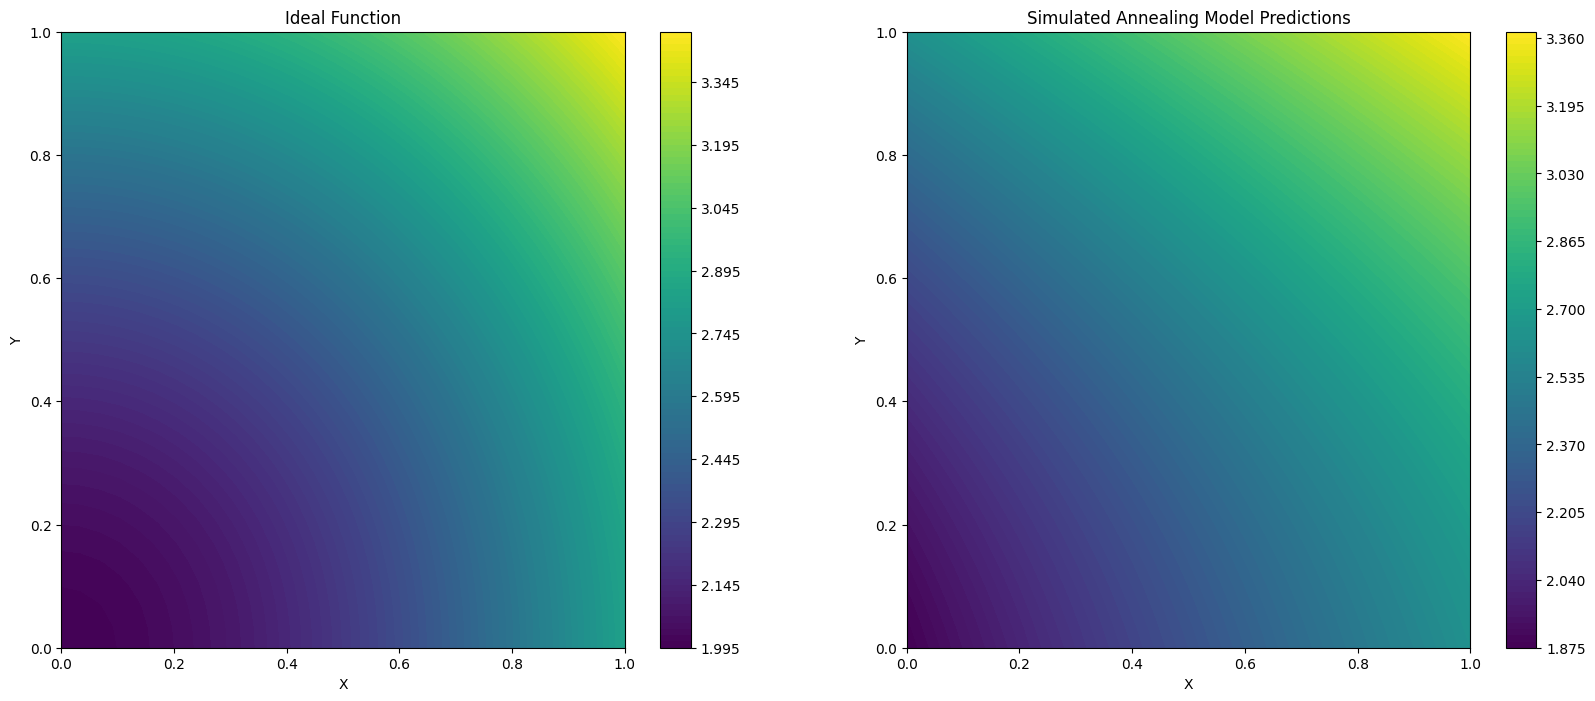

In [12]:
# Compute Bézier curve values for each grid point
B1_values = np.array([[bezier_curve(simulated_optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
B2_values = np.array([[bezier_curve(simulated_optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


# Compute Bézier3 using the output of Bézier1 and Bézier2
Z_model = np.array([[bezier_curve(simulated_optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

# Plotting the 3D surface plots side by side
fig = plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Ideal Function')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the model predictions
plt.subplot(1, 2, 2)
plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Simulated Annealing Model Predictions')
plt.xlabel('X')
plt.ylabel('Y')

In [13]:
# Calculate metrics
# Flatten the arrays for comparison
Z_model_flat = Z_model.ravel()

# Calculate Mean Squared Error (MSE)
simulated_annealing_mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

# Calculate R-squared (R²)
simulated_annealing_r2 = r2_score(Z_ideal_flat, Z_model_flat)

print(f"simulated_annealing_mse: {simulated_annealing_mse}")
print(f"simulated_annealing_r2: {simulated_annealing_r2}")

simulated_annealing_mse: 0.004094822191760347
simulated_annealing_r2: 0.9633768352864004


# Run Quantum Annealing with degree1=2

In [14]:
degree1 = 2
num_basis_funcs_1 = degree1 + 1

In [15]:
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist()
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
for var in enumerate(sorted(Solving_for_vars)):
    index += 1
    # print(var)
    var = str(var[1])
    if '_' in var:
        parts = str(var).split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]
    else:
        aux_num = var.replace('AUX','')
        sympy_to_pyqubo_map[f"{var}"] = coefficients_aux[int(aux_num)]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm)     

# Since the quantum annealer is remote and has a queue time we are only calculating the time spent on the annealer and not incuding the time waiting in the queue

In [16]:
for i in range(number_of_quantum_annealing_tries):
    response = sampler.sample(bqm)

    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
        
    
    annealing_coefficients_2.append([optimized_coefficients_1, optimized_coefficients_2, optimized_coefficients_3])
    
    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    quantum_mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    quantum_r2 = r2_score(Z_ideal_flat, Z_model_flat)
    
    annealing_mses_degree1_2.append(quantum_mse)
    annealing_r2_degree1_2.append(quantum_r2)

In [17]:
print(f"annealing_mses_degree1_2: {annealing_mses_degree1_2}")
print(f"annealing_r2_degree1_2: {annealing_r2_degree1_2}")
print(f"annealing_coefficients_2: {annealing_coefficients_2}")

annealing_mses_degree1_2: [0.0088833313336937, 0.022651372403368293, 0.028853602090043357, 0.03134919828269189, 0.020172558504571652, 0.025860302045867475, 0.05983700933266034, 0.035234833940089395, 0.04959959183638121, 0.016583209946480475, 0.006671669585788105, 0.033385447757872354, 0.03166552324573232, 0.024256813972832754, 0.015533844290126619, 0.05875246163810716, 0.03965671551212032, 0.04366896218762995, 0.023171356710698494, 0.01772641344019761, 0.0331099762391017, 0.029215945187867288, 0.03271297438994102, 0.011052871152067986, 0.01736479357762512, 0.03569752455604386, 0.03152957778638254, 0.05100770641552243, 0.027396681080777516, 0.03411584109169253, 0.025752751249341024, 0.03512094481766008, 0.03951983719016745, 0.040219308929527, 0.03642538558901667, 0.011268460464256492, 0.028186590103983625, 0.01928978936102784, 0.0287591956846059, 0.022545929893401966, 0.03912673957533876, 0.05702548465719149, 0.01864306066270192, 0.044416969261463476, 0.052319926808063515, 0.04215259142

# Now for simulated annealing

In [18]:
# Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
simulated_response = simulated_sampler.sample_qubo(qubo, num_reads=100000)

In [19]:
simulated_solution = simulated_response.first.sample
# Extract optimized coefficients
simulated_optimized_coefficients_1 = []
for i in range(num_basis_funcs_1):
    simulated_coeff_value_1 = sum(2**j * simulated_solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
    simulated_optimized_coefficients_1.append(simulated_coeff_value_1)
    
simulated_optimized_coefficients_2 = []
for i in range(num_basis_funcs_2):
    simulated_coeff_value_2 = sum(2**j * simulated_solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
    simulated_optimized_coefficients_2.append(simulated_coeff_value_2)
    
simulated_optimized_coefficients_3 = []
for i in range(num_basis_funcs_3):
    simulated_coeff_value_3 = sum(2**j * simulated_solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
    simulated_optimized_coefficients_3.append(simulated_coeff_value_3)
    
simulated_optimized_aux = []
for i in range(num_aux):
    simulated_coeff_value_1 = simulated_solution[f'aux[{i}]']
    simulated_optimized_aux.append(simulated_coeff_value_1)


In [20]:
print(f"simulated_optimized_coefficients_1: {simulated_optimized_coefficients_1}")
print(f"simulated_optimized_coefficients_2: {simulated_optimized_coefficients_2}")
print(f"simulated_optimized_coefficients_3: {simulated_optimized_coefficients_3}")

simulated_optimized_coefficients_1: [1.0, 1.25, 1.75]
simulated_optimized_coefficients_2: [0.75, 1.25, 1.625]
simulated_optimized_coefficients_3: [0, 1]


## Optionally Check to make sure aux vars were enforced (recommended if you see issues in your data)

In [21]:
# Separate coefficients and auxiliary variables
aux_vars, coeff_vars = separate_vars(simulated_solution)
# Create reverse lookup dictionary
reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
# Map solution variables from PyQUBO to SymPy
mapped_solution = map_solution_variables(solution, reverse_dict)
include_aux_in_binary = True
aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
# Check the auxiliary variable values
results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

# Print the results
for aux_var, is_correct in results_aux_check.items():
    print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

AUX144: Correct
AUX106: Correct
AUX46: Correct
AUX153: Correct
AUX57: Correct
AUX61: Correct
AUX201: Correct
AUX205: Correct
AUX79: Correct
AUX54: Correct
AUX51: Correct
AUX196: Correct
AUX25: Correct
AUX59: Correct
AUX9: Correct
AUX113: Correct
AUX197: Correct
AUX38: Correct
AUX21: Correct
AUX141: Correct
AUX156: Correct
AUX14: Correct
AUX16: Correct
AUX10: Correct
AUX174: Correct
AUX124: Correct
AUX35: Correct
AUX33: Correct
AUX18: Correct
AUX72: Correct
AUX200: Correct
AUX2: Correct
AUX105: Correct
AUX75: Correct
AUX80: Correct
AUX13: Correct
AUX167: Correct
AUX193: Correct
AUX185: Correct
AUX187: Correct
AUX58: Correct
AUX81: Correct
AUX63: Correct
AUX0: Correct
AUX84: Correct
AUX73: Correct
AUX178: Correct
AUX48: Correct
AUX60: Correct
AUX98: Correct
AUX50: Correct
AUX210: Correct
AUX43: Correct
AUX76: Correct
AUX42: Correct
AUX107: Correct
AUX66: Correct
AUX146: Correct
AUX183: Correct
AUX122: Correct
AUX115: Correct
AUX4: Correct
AUX12: Correct
AUX131: Correct
AUX92: Correct
AUX

# Plot the output of the simulated annealing optimized KAN

Text(0, 0.5, 'Y')

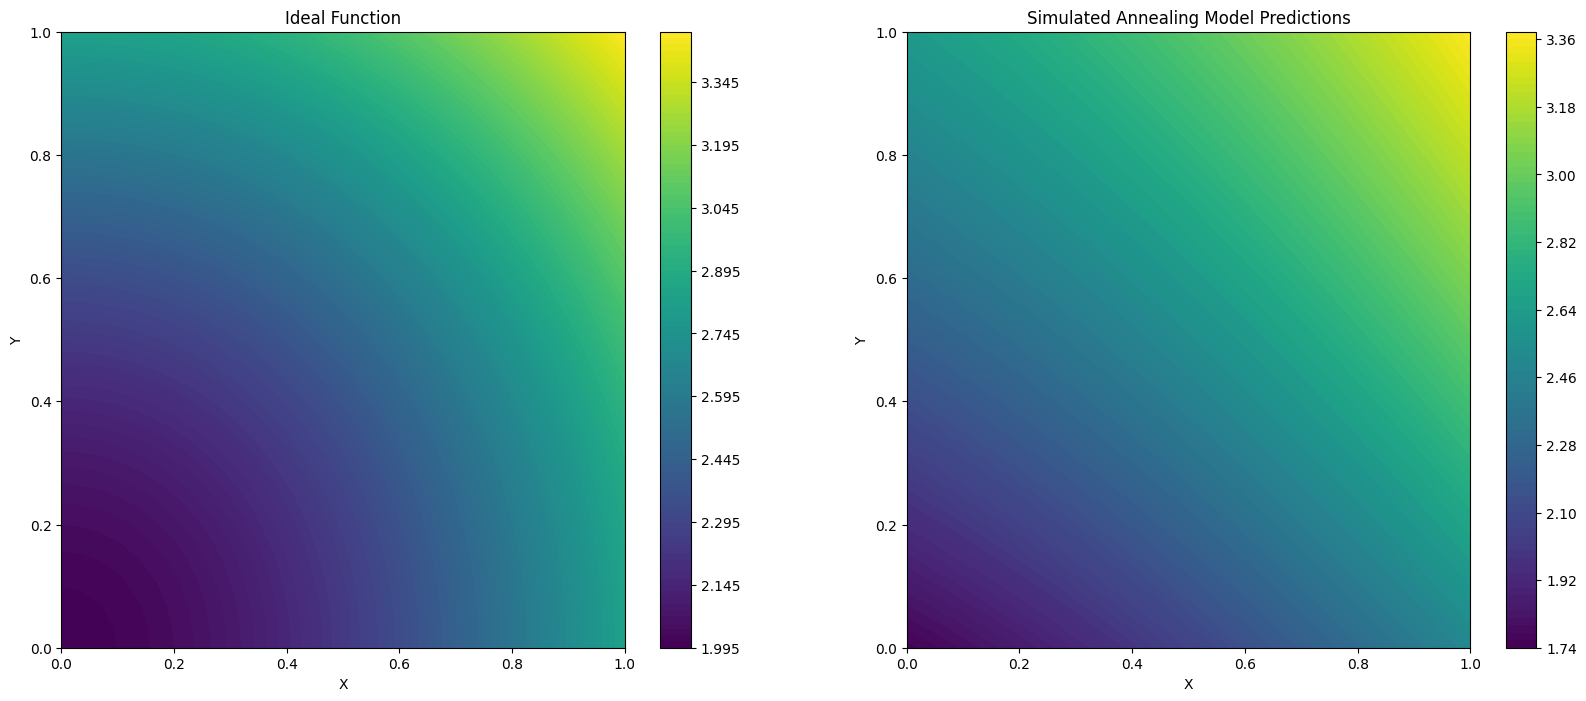

In [22]:
# Compute Bézier curve values for each grid point
B1_values = np.array([[bezier_curve(simulated_optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
B2_values = np.array([[bezier_curve(simulated_optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


# Compute Bézier3 using the output of Bézier1 and Bézier2
Z_model = np.array([[bezier_curve(simulated_optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

# Plotting the 3D surface plots side by side
fig = plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Ideal Function')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the model predictions
plt.subplot(1, 2, 2)
plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Simulated Annealing Model Predictions')
plt.xlabel('X')
plt.ylabel('Y')

In [23]:
# Calculate metrics
# Flatten the arrays for comparison
Z_model_flat = Z_model.ravel()

# Calculate Mean Squared Error (MSE)
simulated_annealing_mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

# Calculate R-squared (R²)
simulated_annealing_r2 = r2_score(Z_ideal_flat, Z_model_flat)

print(f"simulated_annealing_mse: {simulated_annealing_mse}")
print(f"simulated_annealing_r2: {simulated_annealing_r2}")

simulated_annealing_mse: 0.0072125108780634484
simulated_annealing_r2: 0.9354929319232805


# Save the dataset

In [24]:
import pickle

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_10_19_iterative_tries.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset, f)

print(f"Dataset saved to {dataset_file}")

Dataset saved to dataset_2_1_10_19_iterative_tries.pkl
